# About

This notebook is a basic example for looking at individual events, events, creating a solution and submitting it. It walks through some of the library function for accessing the data and writing a submission file. 
This example uses DBScan to solve the tracking problem. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

In [2]:
# Change this according to your directory preferred setting
path_to_train = "../input/train_1"

#  Working on one event

In [3]:
# This event is in Train_1
event_prefix = "event000001000"

## Read and look

In [4]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [5]:
hits.head()

## Identify tracks 

In this example the track pattern recognition is solved as clustering problem. Each of the clusters corresponds to one track. 
Firstly we preprocess hit coordinates in order to highlight the fact that a track is (approximatly) an arc of helix. 


$$ 
r_{1} = \sqrt{x^{2}+y^{2}+z^{2}}
$$

$$
x_{2} = x / r_{1}
$$
$$
y_{2} = y / r_{1}
$$

$$
r_{2} = \sqrt{x^{2}+y^{2}}
$$

$$
z_{2} = z / r_{2}
$$



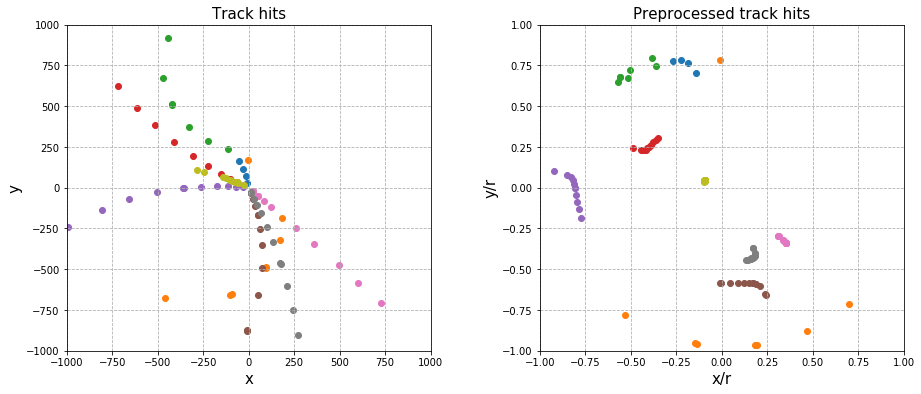

Then, DBSCAN is used to recognize hit clusters. 

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [7]:
model = Clusterer(eps=0.008)
labels = model.predict(hits)

In [8]:
print(labels)

## Score

Compute the score for this event. The dummy submission output of create_one_event_submission  is created only to be the second parameter of the score_event function. It should not be confused with a well-behaved submission for the test set. 

In [9]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [10]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [11]:
print("Your score: ", score)

# Recognize tracks in all events of a dataset
In this example, the dataset is the whole training set.   
This is a simple loop over the one-event actions: because of the use of DBScan, there is no actual training.

This may take a very long time. To run on only a subset, use

     load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

In [12]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=0, nevents=5):
        
    # Track pattern recognition
    model = Clusterer(eps=0.008)
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

# Create a submission

Create a submission file. 

In [13]:
path_to_test = "../input/test"
test_dataset_submissions = []

create_submission = False # True for submission 

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        model = Clusterer(eps=0.008)
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submussion = pd.concat(test_dataset_submissions, axis=0)
    submussion.to_csv('submission.csv.gz', index=False, compression='gzip')